<a href="https://colab.research.google.com/github/maysalimi/heart-disease-prediction-xgboost-SHAP/blob/main/EHR_Version2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
import shap
shap.initjs()  # Enables JS-based SHAP plots in Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Correct path to the file inside your Google Drive
filepath = '/content/drive/My Drive/CIBB/framingham.csv'

# Load the dataset from Google Drive
data = pd.read_csv(filepath)

Mounted at /content/drive


In [ ]:
# Impute missing values using median
data = data.fillna(data.median(numeric_only=True))

# Verify that all missing values are gone
print("\nMissing values after imputation:")
print(data.isnull().sum())

# Rename gender column if necessary
if 'male' in data.columns:
    data = data.rename(columns={'male': 'gender'})

# Encode gender as binary (Male=1, Female=0)
if data['gender'].dtype == 'object':
    data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})


Missing values after imputation:
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


In [ ]:
# Define input features and target variable
features = ['age', 'gender', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
target = 'TenYearCHD'

X = data[features]
y = data[target]

# Standardize (scale) features to mean=0, std=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_scaled, y)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy from GridSearchCV:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy from GridSearchCV: 0.8511792452830189


In [ ]:
# Use the best parameters from GridSearchCV
best_model = grid_search.best_estimator_

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.8584905660377359

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       725
           1       0.67      0.05      0.09       123

    accuracy                           0.86       848
   macro avg       0.76      0.52      0.51       848
weighted avg       0.83      0.86      0.80       848



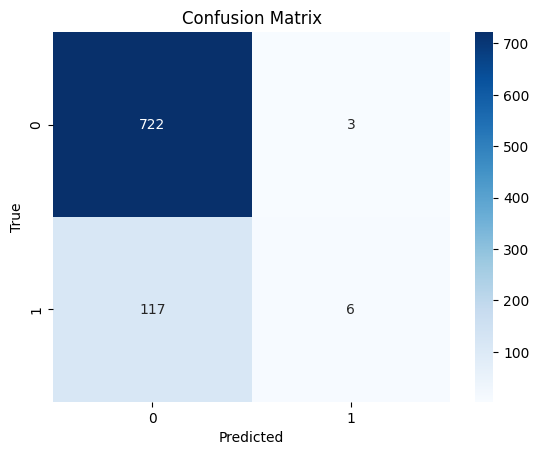

In [ ]:
# Predict on test data
y_pred = best_model.predict(X_test)

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print precision, recall, F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

 99%|===================| 838/848 [00:25<00:00]       

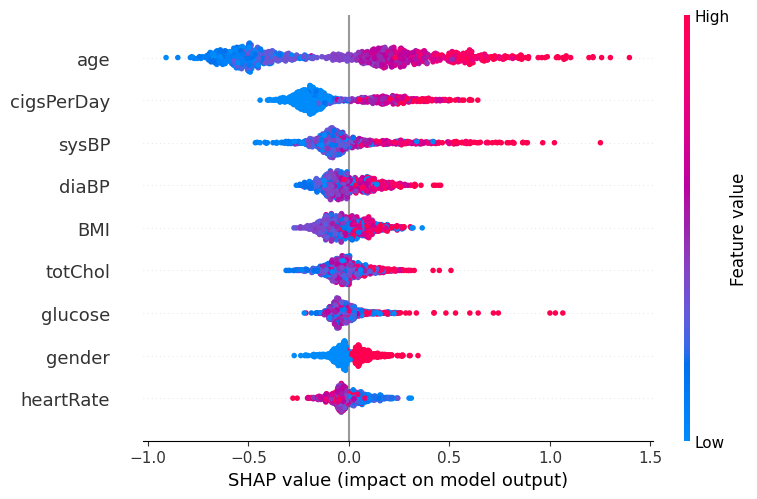

In [ ]:
# SHAP KernelExplainer for XGBoost
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values on test set
shap_values = explainer(X_test)

# SHAP summary plot — most important features
shap.summary_plot(shap_values, X_test, feature_names=features)

In [ ]:
# Check the shape of the dataset
print("Dataset shape (rows, columns):", data.shape)

Dataset shape (rows, columns): (4240, 16)
